In [1]:
import numpy as np
import pandas as pd 

#Read in data, requires 'ISO-8859-1' encoding due to utf-8 encoding error
nhs = pd.read_csv("datasets/GP Prescribing - August 2017 (csv).csv", encoding = 'ISO-8859-1')
nhs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 474571 entries, 0 to 474570
Data columns (total 19 columns):
PRACTICE             470328 non-null float64
Year                 470328 non-null float64
Month                470328 non-null float64
VTM_NM               470328 non-null object
VMP_NM               470328 non-null object
AMP_NM               470328 non-null object
Presentation         466615 non-null object
Strength             425122 non-null object
Total Items          470328 non-null float64
Total Quantity       470328 non-null float64
Gross Cost (£)       470328 non-null float64
Actual Cost (£)      470328 non-null float64
BNF Code             470328 non-null object
BNF Chapter          470328 non-null float64
BNF Section          470328 non-null float64
BNF Paragraph        470328 non-null float64
BNF Sub-Paragraph    470328 non-null float64
Unnamed: 17          0 non-null float64
Unnamed: 18          0 non-null float64
dtypes: float64(13), object(6)
memory usage: 68.8+

In [2]:
#Description summary for NHS data, remove unnamed 17 and 18 as they are empty. Also remove gross cost
nhs = nhs.drop('Unnamed: 17', axis = 1)
nhs = nhs.drop('Unnamed: 18', axis = 1)
nhs = nhs.drop('Gross Cost (£)', axis = 1)
nhs.describe()

,PRACTICE,Year,Month,Total Items,Total Quantity,Actual Cost (£),BNF Chapter,BNF Section,BNF Paragraph,BNF Sub-Paragraph
count,470328.000000,470328.0,470328.0,470328.000000,470328.000000,470328.000000,470328.000000,470328.000000,470328.000000,470328.000000
mean,344.938507,2017.0,8.0,7.286540,730.593097,71.248447,7.017503,5.472532,2.827818,0.292298
std,189.829958,0.0,0.0,20.244422,2983.929582,175.755410,5.859775,8.502812,10.300587,0.768548
min,1.000000,2017.0,8.0,1.000000,0.000000,0.010000,1.000000,0.000000,0.000000,0.000000
25%,195.000000,2017.0,8.0,1.000000,30.000000,7.840000,3.000000,2.000000,1.000000,0.000000
50%,350.000000,2017.0,8.0,2.000000,112.000000,22.930000,5.000000,4.000000,1.000000,0.000000
75%,507.000000,2017.0,8.0,5.000000,371.000000,65.220000,10.000000,7.000000,2.000000,0.000000
max,664.000000,2017.0,8.0,1105.000000,294000.000000,12213.630000,99.000000,99.000000,99.000000,9.000000


In [3]:
#Define numeric values and categorical values, also remove year and month as they are fixed
nhs = nhs.drop('Year', axis = 1)
nhs = nhs.drop('Month', axis = 1)

numeric_values = ['PRACTICE', 'Total Items',
                  'Total Quantity', 'Actual Cost (£)',
                  'BNF Chapter', 'BNF Section', 'BNF Paragraph', 'BNF Sub-Paragraph']

categoric_values = list(nhs)
for value in numeric_values:
    categoric_values.remove(value)

In [4]:
#Build Feature Pipeline which performs several functions,
#
#   -Selects the approapriate dataframe according to whether its categorical or numeric
#
#   -Tries to fill missing numeric data using the median
#
#   -One Hot Encodes the categorical value for each categorical column
#
#   -Standard Scales the numerical data
#

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, Imputer, LabelBinarizer
from utils.DataFrameSelector import DataFrameSelector
from utils.Binarizer import Binarizer

nhs[categoric_values] = nhs[categoric_values].replace('-', np.nan)
nhs[categoric_values] = nhs[categoric_values].replace('', np.nan)
nhs = nhs.dropna(subset = categoric_values)

numeric_pipe = Pipeline([('select', DataFrameSelector(numeric_values)),
                         ('impute', Imputer(strategy = "median")),
                         ('std', StandardScaler()),])

categoric_pipe = Pipeline([('select', DataFrameSelector(categoric_values)),
                           ('binarizer', Binarizer()),])

feature_pipe = FeatureUnion(transformer_list = [('num_pipe', numeric_pipe), ('cat_pipe', categoric_pipe)])

In [5]:
#Only processing numerical values since the categorical pipeline is untested
processed_nhs = numeric_pipe.fit_transform(nhs)

C:\Users\srder\Miniconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.
  """


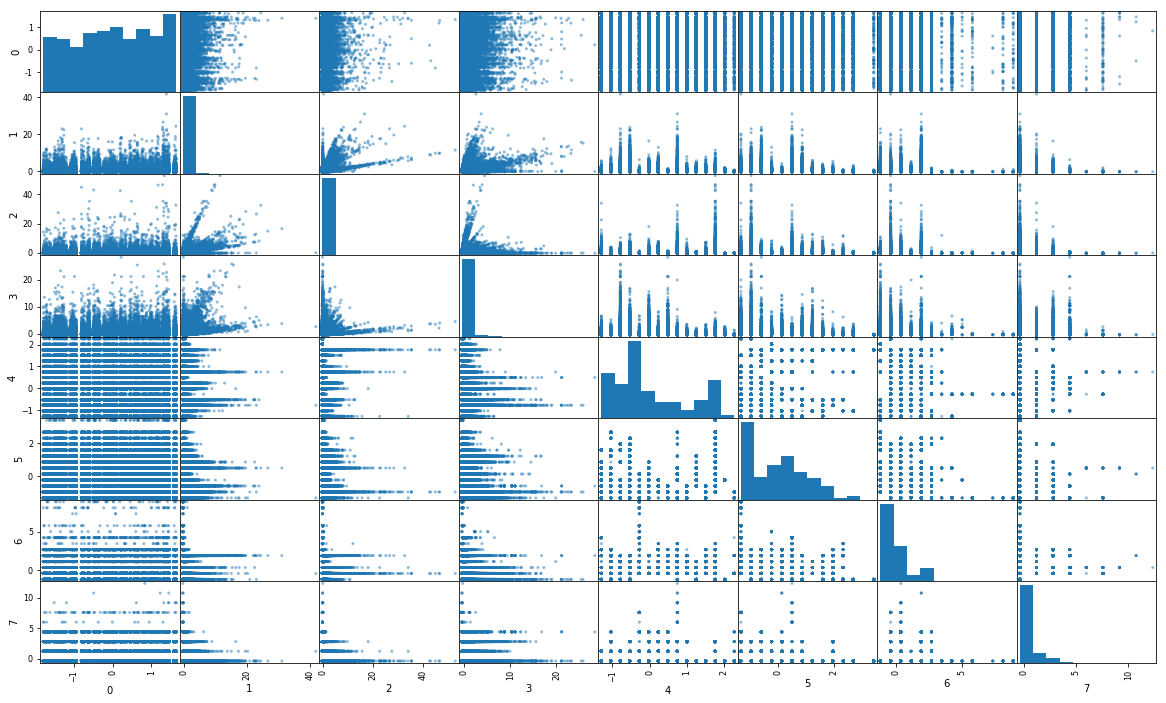

In [7]:
#Plot correlation matrix of numeric values
import matplotlib.pyplot as plt 
from pandas.tools.plotting import scatter_matrix

scatter_matrix(pd.DataFrame(processed_nhs), figsize = (20, 12))
plt.show()

In [8]:
#Also print the indexing for each variable to make the graph easier to read
for num in range(processed_nhs.shape[1]):
    print(num, " - ", numeric_values[num])

0  -  PRACTICE
1  -  Total Items
2  -  Total Quantity
3  -  Actual Cost (£)
4  -  BNF Chapter
5  -  BNF Section
6  -  BNF Paragraph
7  -  BNF Sub-Paragraph


In [9]:
#Print out of the correlations with respect to the Actual Cost
corr_matrix = pd.DataFrame(processed_nhs).corr()
print("Correlations:")
for num in range(processed_nhs.shape[1]):
    print(numeric_values[num], " - ", corr_matrix.iloc[:,3][num])

Correlations:
PRACTICE  -  0.0100402680966
Total Items  -  0.459368818972
Total Quantity  -  0.134639283466
Actual Cost (£)  -  1.0
BNF Chapter  -  -0.119124448721
BNF Section  -  -0.0801850755392
BNF Paragraph  -  -0.0191485432517
BNF Sub-Paragraph  -  0.0833507581479


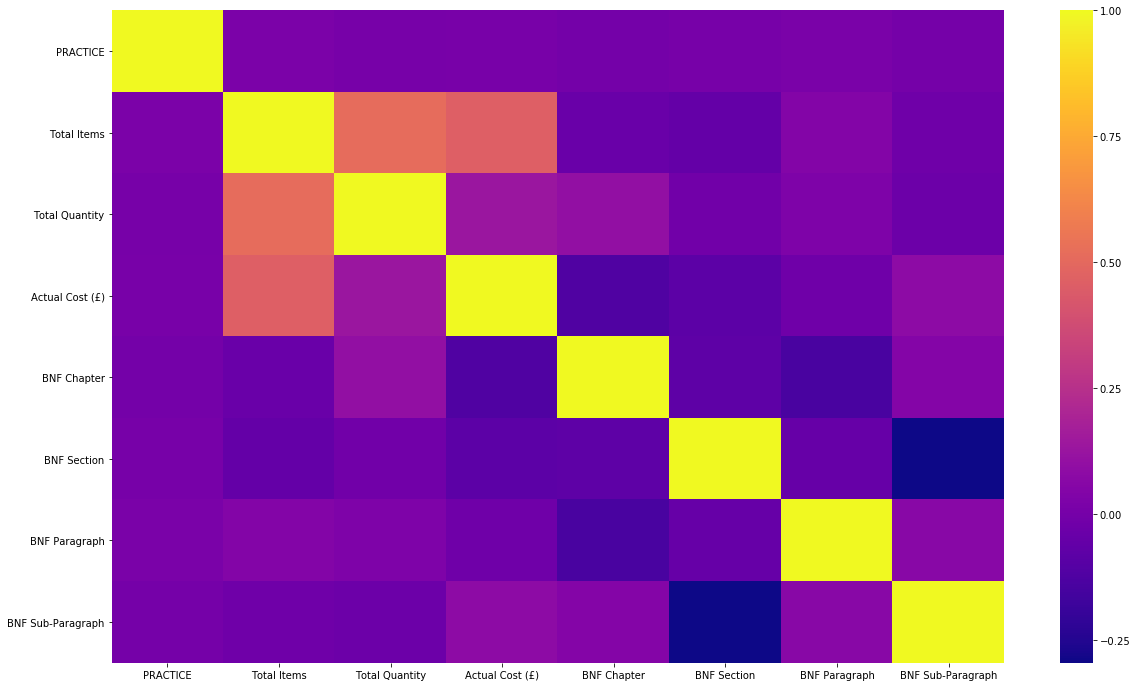

In [10]:
#Seaborn heatmap of correlation for more transparency
import seaborn as sns
plt.figure(figsize=(20,12))
sns.heatmap(corr_matrix, 
            xticklabels=numeric_values,
            yticklabels=numeric_values,
            cmap="plasma")
plt.show()